In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import cv2
import os
np.random.seed(0)
torch.manual_seed(0)

In [3]:
path='/content/drive/My Drive/Colab Notebooks/Data/flowers/flowers/'

img_names = []
for folder,_,filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
print("images len:",len(img_names))

images len: 4326


In [4]:
transform = {
    "train": transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.5),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.452,0.413,0.294], std =[0.248,0.218,0.221])
    ]),
    "Test": transforms.Compose({
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.452,0.413,0.294], std =[0.248,0.218,0.221])
    })
}

In [5]:
root='/content/drive/My Drive/Colab Notebooks/Data/flowers/'

full_dataset = datasets.ImageFolder(os.path.join(root,'flowers'),transform=transform["train"])
print('full dataset:',full_dataset)

full dataset: Dataset ImageFolder
    Number of datapoints: 4323
    Root location: /content/drive/My Drive/Colab Notebooks/Data/flowers/flowers
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.5, 1.5], contrast=None, saturation=None, hue=None)
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.452, 0.413, 0.294], std=[0.248, 0.218, 0.221])
           )


In [6]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

print('train size:',train_size)
print('test size:',test_size)
train_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train size: 3458
test size: 865


In [7]:
train_btch_size =32
test_btch_size = 16

train_loader = DataLoader(train_data,batch_size=train_btch_size, shuffle = True,num_workers = 8)
test_loader =  DataLoader(test_data,batch_size =test_btch_size ,shuffle = False,num_workers = 8)

class_names = full_dataset.classes
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


## CNN Model: Pretrained VGG-16

In [8]:
VGG16_model = models.vgg16_bn(pretrained=True)

# set parameter requires grad ##
for param in VGG16_model.parameters():
  param.requires_grad = False

num_ftrs = VGG16_model.classifier[6].in_features
VGG16_model.classifier[6] = nn.Linear(num_ftrs,5) # 5 classes

print(VGG16_model)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 25

In [9]:
# We are going to use pytorch GPU therefore we need to convert datatypes into .cuda() format
from torch.autograd import Variable

use_gpu = torch.cuda.is_available()
if use_gpu:
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
else:
  print("GPU not avaliable")

1
Tesla K80


In [10]:
params_to_update=[]
for name,param in VGG16_model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print("\t",name)

# Loss Function
if use_gpu:
    VGG16_model.cuda() 
criterion= nn.CrossEntropyLoss()
if use_gpu:
     criterion = criterion.cuda()

# Optimizer
optimizer = torch.optim.Adam(params_to_update,lr=0.001)# default betas=(0.9,0.999)

	 classifier.6.weight
	 classifier.6.bias


In [11]:
%%time
epochs = 50
train_losses =[]
test_losses = []
train_correct =[]
test_correct=[]
for epoch in range(epochs):
    
    trn_corr =0
    tst_corr =0
    for batch,(X_train,y_train) in enumerate(train_loader):
        batch+=1
        if torch.cuda.is_available():
            X_train = Variable(X_train).cuda()
            y_train = Variable(y_train).cuda()
        
        y_pred = VGG16_model(X_train)
        loss   = criterion(y_pred,y_train)
        predicted =torch.max(y_pred.data,1)[1]
        trn_corr+=(predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch%100 ==0:
            print(f'epoch:{epoch} batch:{batch} loss:{loss.item()} accuracy:{trn_corr.item()*100/(batch*train_btch_size)}')
            
        
    train_losses.append(loss)
    train_correct.append(trn_corr.item()*100/(batch*train_btch_size))
    
    with torch.no_grad():
        for batch,(X_test,y_test) in enumerate(test_loader):
            
            if torch.cuda.is_available():
                X_test = Variable(X_test).cuda()
                y_test = Variable(y_test).cuda()

            y_val= VGG16_model(X_test)
            predicted_test = torch.max(y_val.data,1)[1]
            tst_corr +=(predicted_test==y_test).sum()

        loss =criterion(y_val,y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr.item()*100/(batch*test_btch_size))  
    

epoch:0 batch:100 loss:0.39784693717956543 accuracy:75.25
epoch:1 batch:100 loss:0.23563891649246216 accuracy:83.9375
epoch:2 batch:100 loss:0.7185529470443726 accuracy:83.84375
epoch:3 batch:100 loss:0.4367307424545288 accuracy:84.84375
epoch:4 batch:100 loss:0.32346755266189575 accuracy:85.34375
epoch:5 batch:100 loss:0.36067354679107666 accuracy:85.8125
epoch:6 batch:100 loss:0.4392995536327362 accuracy:86.34375
epoch:7 batch:100 loss:0.20711834728717804 accuracy:85.6875
epoch:8 batch:100 loss:0.2803054451942444 accuracy:86.53125
epoch:9 batch:100 loss:0.52076256275177 accuracy:86.15625
epoch:10 batch:100 loss:0.6886429786682129 accuracy:86.6875
epoch:11 batch:100 loss:0.27282923460006714 accuracy:86.3125
epoch:12 batch:100 loss:0.5339343547821045 accuracy:87.0625
epoch:13 batch:100 loss:0.30858173966407776 accuracy:87.03125
epoch:14 batch:100 loss:0.516018807888031 accuracy:87.21875
epoch:15 batch:100 loss:0.3007160425186157 accuracy:87.21875
epoch:16 batch:100 loss:0.3754876852035

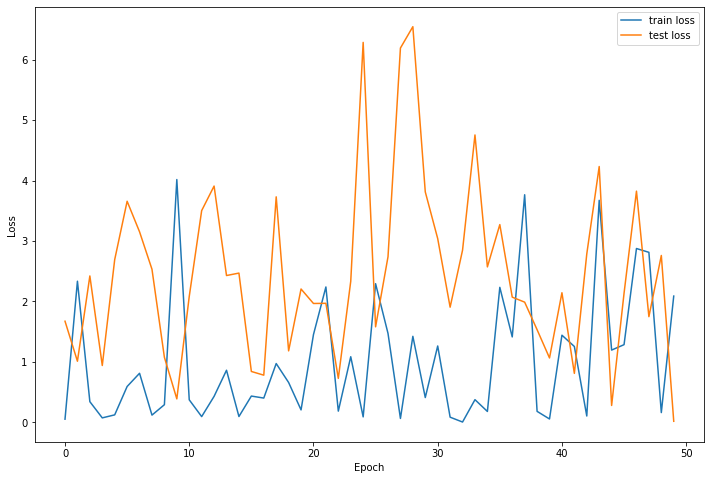

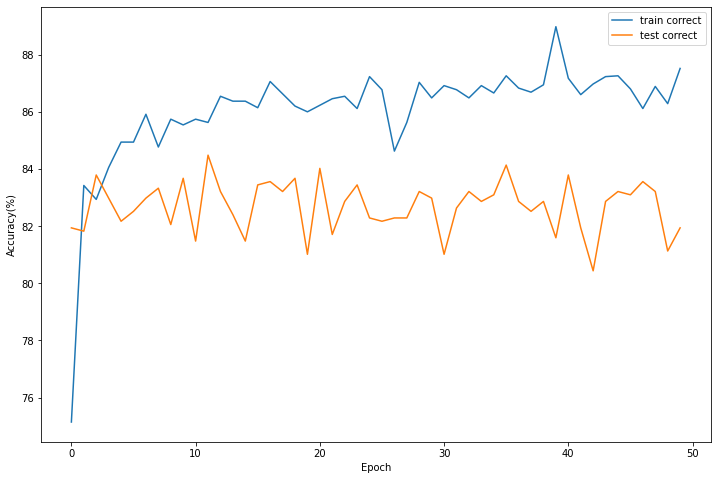

In [12]:
#  Plot train loss and test loss 
plt.figure(figsize=(12,8))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses,label = 'train loss')
plt.plot(test_losses,label  = 'test loss')
plt.legend()

#  Plot train and test accuracy
plt.figure(figsize=(12,8))
plt.xlabel("Epoch")
plt.ylabel("Accuracy(%)")
plt.plot(train_correct,label = 'train correct')
plt.plot(test_correct, label = 'test correct')
plt.legend()